# Variables

In [1]:
source("/home/vickydiliscia/dmeyf2025/src/competencia/experimento/config.r")
source("/home/vickydiliscia/dmeyf2025/src/competencia/experimento/utils/04_entrenar_modelos.R")
source("/home/vickydiliscia/dmeyf2025/src/competencia/experimento/utils/05_ensamblar_promedio.R")
source("/home/vickydiliscia/dmeyf2025/src/competencia/experimento/config.r")

## Semillas
PARAM <- list()
PARAM$semilla_primigenia <- SEEDS[1]
PARAM$experimento <- 5001
# training y future
PARAM$train <- c(202102)
PARAM$train_final <- c(202101,202102,202103)
PARAM$future <- c(202104)
PARAM$future_final <- c(202104)
PARAM$semilla_kaggle <- 314159
PARAM$cortes <- seq(6000, 19000, by= 500)

# undersampling
PARAM$trainingstrategy$undersampling <- 0.3

# carpeta de trabajo
setwd("/content/buckets/b1/exp")
experimento_folder <- paste0("HT", PARAM$experimento)
dir.create(experimento_folder, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento_folder ))

# Parametros LGBM

In [2]:
PARAM$hyperparametertuning$xval_folds <- 5

# parametros fijos del LightGBM que se pisaran con la parte variable de la BO
PARAM$lgbm$param_fijos <-  list(
  boosting= "gbdt", # puede ir  dart  , ni pruebe random_forest
  objective= "binary",
  metric= "auc",
  first_metric_only= FALSE,
  boost_from_average= TRUE,
  feature_pre_filter= FALSE,
  force_row_wise= TRUE, # para reducir warnings
  verbosity= -100,

  seed= PARAM$semilla_primigenia,

  max_depth= -1L, # -1 significa no limitar,  por ahora lo dejo fijo
  min_gain_to_split= 0, # min_gain_to_split >= 0
  min_sum_hessian_in_leaf= 0.001, #  min_sum_hessian_in_leaf >= 0.0
  lambda_l1= 0.0, # lambda_l1 >= 0.0
  lambda_l2= 0.0, # lambda_l2 >= 0.0
  max_bin= 31L, # lo debo dejar fijo, no participa de la BO

  bagging_fraction= 1.0, # 0.0 < bagging_fraction <= 1.0
  pos_bagging_fraction= 1.0, # 0.0 < pos_bagging_fraction <= 1.0
  neg_bagging_fraction= 1.0, # 0.0 < neg_bagging_fraction <= 1.0
  is_unbalance= FALSE, #
  scale_pos_weight= 1.0, # scale_pos_weight > 0.0

  drop_rate= 0.1, # 0.0 < neg_bagging_fraction <= 1.0
  max_drop= 50, # <=0 means no limit
  skip_drop= 0.5, # 0.0 <= skip_drop <= 1.0

  extra_trees= FALSE,

  num_iterations= 1200,
  learning_rate= 0.02,
  feature_fraction= 0.5,
  num_leaves= 750,
  min_data_in_leaf= 5000
)

# Librerias

In [3]:
# cargo las librerias que necesito
require("data.table")
require("parallel")

if(!require("R.utils")) install.packages("R.utils")
require("R.utils")

if( !require("primes") ) install.packages("primes")
require("primes")

if( !require("utils") ) install.packages("utils")
require("utils")

if( !require("rlist") ) install.packages("rlist")
require("rlist")

if( !require("yaml")) install.packages("yaml")
require("yaml")

if( !require("lightgbm") ) install.packages("lightgbm")
require("lightgbm")

if( !require("DiceKriging") ) install.packages("DiceKriging")
require("DiceKriging")

if( !require("mlrMBO") ) install.packages("mlrMBO")
require("mlrMBO")

Loading required package: parallel

Loading required package: R.utils

Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.27.1 (2025-05-02 21:00:05 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.13.0 (2025-02-24 21:20:02 UTC) successfully loaded. See ?R.utils for help.


Attaching package: ‘R.utils’


The following object is masked from ‘package:utils’:

    timestamp


The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings


Loading required package: primes

Loading required package: rlist

Loading required packa

# Dataset

In [4]:
# lectura del dataset
dataset <- fread(DATASET_FEATURES, stringsAsFactors= TRUE)

# Tomo hiperparametros

In [5]:
kbayesiana <- "bayesiana.RDATA"  # tu archivo con el opt.state adentro
# Cargar el archivo (esto mete en memoria los objetos guardados, p. ej. opt.state)
load(kbayesiana)

# Si el archivo contiene el estado de la optimización:
bayesiana_salida <- list(opt.path = opt.state$opt.path)
                         
tb_bayesiana <- as.data.table(bayesiana_salida$opt.path)
colnames( tb_bayesiana)

# almaceno los resultados de la Bayesian Optimization
# y capturo los mejores hiperparametros encontrados

tb_bayesiana <- as.data.table(bayesiana_salida$opt.path)

tb_bayesiana[, iter := .I]

# ordeno en forma descendente por AUC = y
setorder(tb_bayesiana, -y)

# grabo para eventualmente poder utilizarlos en OTRA corrida
fwrite( tb_bayesiana,
  file= "BO_log.txt",
  sep= "\t"
)

# los mejores hiperparámetros son los que quedaron en el registro 1 de la tabla
PARAM$out$lgbm$mejores_hiperparametros <- tb_bayesiana[
  1, # el primero es el de mejor AUC
  setdiff(colnames(tb_bayesiana),
    c("y","dob","eol","error.message","exec.time","ei","error.model",
      "train.time","prop.type","propose.time","se","mean","iter")),
  with= FALSE
]

PARAM$out$lgbm$y <- tb_bayesiana[1, y]

write_yaml( PARAM, file="PARAM.yml")


print(PARAM$out$lgbm$mejores_hiperparametros)
print(PARAM$out$lgbm$y)

[1] "num_iterations"   "learning_rate"    "feature_fraction" "num_leaves"      
 [5] "min_data_in_leaf" "y"                "dob"              "eol"             
 [9] "error.message"    "exec.time"        "ei"               "error.model"     
[13] "train.time"       "prop.type"        "propose.time"     "se"              
[17] "mean"

   num_iterations learning_rate feature_fraction num_leaves min_data_in_leaf
            <int>         <num>            <num>      <int>            <int>
1:           1375     0.0101999        0.2633874        575              325
[1] 0.92906


# Train ejemplo

In [ ]:
## Dataset para el final train

In [6]:
setwd("/content/buckets/b1/exp")
experimento <- paste0("cortes", PARAM$experimento)
dir.create(experimento, showWarnings= FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento ))

In [ ]:
# clase01
dataset[, clase01 := ifelse(clase_ternaria %in% c("BAJA+1", "BAJA+2"), 1L, 0L)]

dataset_train <- dataset[foto_mes %in% PARAM$train_final]
dataset_train[,.N,clase_ternaria]

campos_buenos <- setdiff(
  colnames(dataset_train),
  c("clase_ternaria", "clase01", "azar", "training")
)

# dejo los datos en el formato que necesita LightGBM

dtrain_final <- lgb.Dataset(
  data= data.matrix(dataset_train[, campos_buenos, with= FALSE]),
  label= dataset_train[, clase01]
)

In [7]:
# clase01
dataset[, clase01 := ifelse(clase_ternaria %in% c("BAJA+1", "BAJA+2"), 1L, 0L)]

dataset_train <- dataset[ foto_mes %in% PARAM$train_final ]
campos_buenos <- setdiff(colnames(dataset_train), c("clase_ternaria","clase01","azar","training"))

# Dataset de LightGBM con max_bin=31
dtrain_final <- lgb.Dataset(
  data  = data.matrix(dataset_train[, ..campos_buenos]),
  label = dataset_train$clase01,
  params = list(max_bin = 31),     # <<--- cambio mínimo
  free_raw_data = FALSE
)
lgb.Dataset.construct(dtrain_final) # (una vez)


## Hiperparametros para el final train

In [8]:
param_final <- modifyList(PARAM$lgbm$param_fijos,
  PARAM$out$lgbm$mejores_hiperparametros)

param_final

$boosting
[1] "gbdt"

$objective
[1] "binary"

$metric
[1] "auc"

$first_metric_only
[1] FALSE

$boost_from_average
[1] TRUE

$feature_pre_filter
[1] FALSE

$force_row_wise
[1] TRUE

$verbosity
[1] -100

$seed
[1] 100271

$max_depth
[1] -1

$min_gain_to_split
[1] 0

$min_sum_hessian_in_leaf
[1] 0.001

$lambda_l1
[1] 0

$lambda_l2
[1] 0

$max_bin
[1] 31

$bagging_fraction
[1] 1

$pos_bagging_fraction
[1] 1

$neg_bagging_fraction
[1] 1

$is_unbalance
[1] FALSE

$scale_pos_weight
[1] 1

$drop_rate
[1] 0.1

$max_drop
[1] 50

$skip_drop
[1] 0.5

$extra_trees
[1] FALSE

$num_iterations
[1] 1375

$learning_rate
[1] 0.0101999

$feature_fraction
[1] 0.2633874

$num_leaves
[1] 575

$min_data_in_leaf
[1] 325

In [9]:
# este punto es muy SUTIL  y será revisado en la Clase 05

param_normalizado <- copy(param_final)
param_normalizado$min_data_in_leaf <-  round(param_final$min_data_in_leaf / PARAM$trainingstrategy$undersampling)
param_normalizado$num_threads <- 8  # no optimizable, solo controla CPU
param_normalizado$max_bin <- NULL         # <<--- clave para no re-definirlo en lgb.train()


In [10]:
# entreno LightGBM

modelo_final <- lgb.train(
  data= dtrain_final,
  param= param_normalizado
)

# Training de modelos

In [ ]:
result <- entrenar_modelos(
  dtrain  = dtrain_final,
  params  = param_normalizado,
  nrounds = 1375,
  seeds   = SEEDS,
  tag     = "5001_us03_lag1_cortes"
)
# paths de modelos guardados:
sapply(result, function(x) x$path)


In [11]:
tag <- "5001_us03_lag1_cortes"

model_paths <- list.files(pattern = paste0("^modelo_", tag, "_seed.*\\.txt$"))
modelos <- lapply(model_paths, lgb.load)

ensamblar_promedio (
  dataset       = dataset,
  PARAM         = PARAM,
  campos_buenos = campos_buenos,
  experimento   = tag,
  models_dir    = ".",
  pattern       = paste0("^modelo_", tag, "_seed.*\\.txt$"),
  out_dir       = "predicciones"
)


✅ Archivo de predicciones guardado en: predicciones/prediccion_5001_us03_lag1_cortes.txt



In [12]:

# 0) Config (por si no quedó en memoria)
pred_file <- "predicciones/prediccion_5001_us03_lag1_cortes.txt"  # tu archivo .txt
if (is.null(PARAM$experimento)) PARAM$experimento <- "prediccion_5001_us03_lag1_cortes"

# 1) Cargar predicciones desde el archivo
tb_prediccion <- fread(pred_file, sep = "\t")  
# Espera columnas: numero_de_cliente, foto_mes, prob

In [14]:
# aplico el modelo a los datos sin clase
dfuture <- dataset[foto_mes %in% PARAM$future_final]

In [15]:
# inicilizo el dataset  drealidad
drealidad <- realidad_inicializar( dfuture, PARAM)

In [19]:
cortes <- PARAM$cortes 

In [38]:
source("/home/vickydiliscia/dmeyf2025/src/competencia/experimento/utils/11_comparar_cortes.R")

In [25]:
comparar_cortes(tb_prediccion, cortes, drealidad)

corte,public,private,total
<dbl>,<dbl>,<dbl>,<dbl>
6000,313000000,356142857,343200000
6500,319266667,359742857,347600000
7000,335533333,369342857,359200000
7500,336333333,367285714,358000000
8000,346266667,372742857,364800000
8500,336933333,380742857,367600000
9000,340133333,387942857,373600000
9500,340533333,384914286,371600000
10000,338200000,385342857,371200000


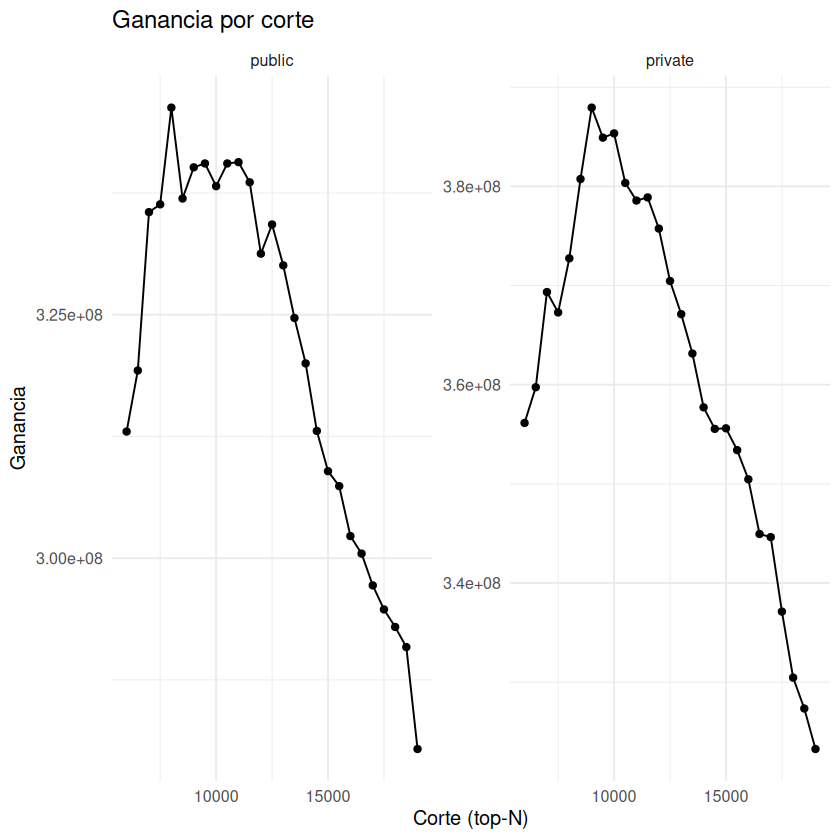

In [26]:
comparaciones <- comparar_cortes(tb_prediccion, cortes, drealidad)
plot_cortes(comparaciones)

In [32]:
semillas <- SEEDS

In [33]:
semillas

[1] 100271 250061 345803 567983 890009 910037 970019 990137 860689 780079

In [39]:
comparar_semillas(
  pfuture       = dfuture,
  pparam        = PARAM,          # o tu lista de parámetros
  tb_prediccion = tb_prediccion,  # con columnas numero_de_cliente, prob
  cortes        = PARAM$cortes,   # p.ej. c(8000, 9000, 10000, ...)
  semillas      = semillas
)

corte,public,private,total,semilla
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6000,340800000,344228571,343200000,100271
6500,344933333,348742857,347600000,100271
7000,351266667,362600000,359200000,100271
7500,355400000,359114286,358000000,100271
8000,353333333,369714286,364800000,100271
8500,359000000,371285714,367600000,100271
9000,369400000,375400000,373600000,100271
9500,365866667,374057143,371600000,100271
10000,368200000,372485714,371200000,100271


In [40]:

res <- comparar_semillas(
  pfuture       = dfuture,
  pparam        = PARAM,          # o tu lista de parámetros
  tb_prediccion = tb_prediccion,  # con columnas numero_de_cliente, prob
  cortes        = PARAM$cortes,   # p.ej. c(8000, 9000, 10000, ...)
  semillas      = semillas
)

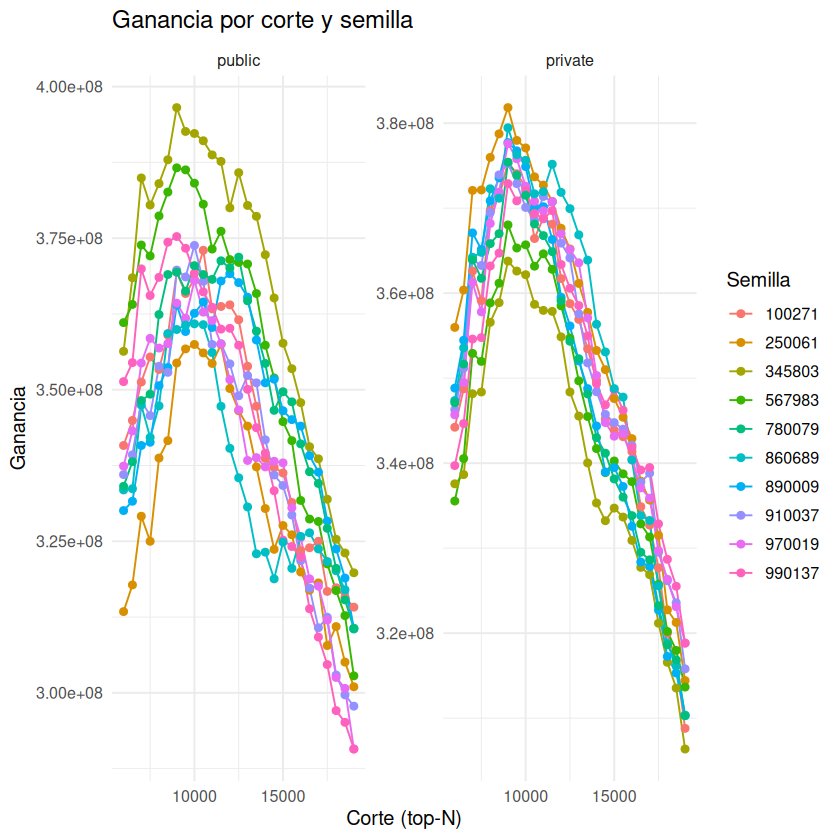

In [41]:
plot_semillas(res)